
# Table of Contents

1. [Introduction](#Introduction)
2. [Import Libraries](#Import-Libraries)
3. [Black-Scholes Model](#Black-Scholes-Model)
4. [Binomial Model](#Binomial-Model)
4. [Monte-Carlo Model](#Monte-Carlo-Model)
5. [Results and Visualizations](#Results-and-Visualizations)




## Concepts: Black-Scholes, Binomial and Monte-Carlo Models

### Black-Scholes Model
The Black-Scholes model is a mathematical framework used for pricing European options. 
It assumes that stock prices follow a geometric Brownian motion with constant volatility and risk-free interest rate.

Code path for this model [here](optionspricer/pricer/blackscholes.py).

### Binomial Model
The binomial model is a discrete-time model for option pricing. It uses a lattice-based approach to model the possible movements of an underlying asset.

Code path for this model [here](optionspricer/pricer/binomial.py).

### Monte-Carlo Model
Monte Carlo methods, or Monte Carlo experiments, are a broad class of 
computational algorithms that rely on repeated random sampling to obtain numerical results. The underlying concept is to use randomness to solve problems that might be deterministic in principle.

Code path for this model [here](optionspricer/pricer/montecarlo.py).



### Import home made librairies

In [54]:
from optionspricer.products.option import Option
from optionspricer.products.underlying import Product
from optionspricer.pricer.blackscholes import BlackScholesPricer
from optionspricer.products.risk_free_rate import MultiCurrencyRiskFreeRate
from optionspricer.pricer.binomial import BinomialPricer
from optionspricer.pricer.montecarlo import MonteCarlo
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import pandas as pd
import datetime as dt
import numpy as np

# Black & Scholes pricing with european option

### S&P 500 ETF based option

In [55]:
etf_sp500 = Product("SPY")
etf_data = etf_sp500.get_stock_data(historic='2y')

px.line(etf_data, x=etf_data.index, y=['Close'], title='S&P 500 based Index').show()

#### Choosing an option

In [56]:
etf_sp500.options_maturities

['2025-01-06',
 '2025-01-07',
 '2025-01-08',
 '2025-01-09',
 '2025-01-10',
 '2025-01-17',
 '2025-01-24',
 '2025-01-31',
 '2025-02-07',
 '2025-02-21',
 '2025-02-28',
 '2025-03-21',
 '2025-03-31',
 '2025-04-17',
 '2025-04-30',
 '2025-05-16',
 '2025-05-30',
 '2025-06-20',
 '2025-06-30',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-09-30',
 '2025-12-19',
 '2025-12-31',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-12-18',
 '2027-01-15']

In [57]:
# Let's choose a call option that expire in next september
option_chain = etf_sp500.calls_puts_for_maturity(
    type="call", expiration_date="2025-09-19"
).sort_values(by=["volume"], ascending=False)
maturity_date = dt.datetime.strptime("2025-09-19", "%Y-%m-%d").date()
display(option_chain)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
80,SPY250919C00640000,2025-01-03 20:49:51+00:00,640.0,12.68,12.70,12.81,2.010000,18.837864,2343.0,8358,0.150689,False,REGULAR,USD
82,SPY250919C00650000,2025-01-03 19:30:00+00:00,650.0,9.39,9.30,9.40,1.640000,21.161295,1162.0,10852,0.143548,False,REGULAR,USD
74,SPY250919C00610000,2025-01-03 20:45:52+00:00,610.0,27.60,27.57,27.71,3.860001,16.259481,664.0,2275,0.178780,False,REGULAR,USD
99,SPY250919C00735000,2024-12-31 15:13:04+00:00,735.0,0.43,0.45,0.47,0.000000,0.000000,504.0,1387,0.123788,False,REGULAR,USD
36,SPY250919C00420000,2024-12-11 17:57:22+00:00,420.0,203.22,184.42,188.02,0.000000,0.000000,302.0,614,0.427008,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,SPY250919C00440000,2024-12-30 20:28:16+00:00,440.0,166.42,165.74,169.35,0.000000,0.000000,1.0,186,0.397543,True,REGULAR,USD
62,SPY250919C00550000,2025-01-03 19:05:19+00:00,550.0,70.82,70.10,71.56,5.389999,8.237810,1.0,1367,0.249397,True,REGULAR,USD
76,SPY250919C00620000,2025-01-03 16:36:16+00:00,620.0,21.52,21.90,22.03,2.729999,14.529001,1.0,6239,0.168572,False,REGULAR,USD
24,SPY250919C00360000,2024-12-24 18:12:42+00:00,360.0,253.33,241.23,244.85,0.000000,0.000000,1.0,20,0.522893,True,REGULAR,USD


In [58]:
# So I've choose the one with most volume.
sp500_option = Option("SPY250919C00640000")

#### Option data

In [59]:
S, K, T, sigma, option_type, currency = sp500_option.get_option_data()

# dividend yield
q = etf_sp500.get_dividend_yield.values[0]

print(
    "Spot: {:.2f}, Strike: {}, Maturity: {:.3f}, Volatitlity: {:.4%},\nType: {}, Currency: {}, Dividend yield: {:.4%}".format(
        S, K, T, sigma, option_type, currency, q
    )
)

Spot: 591.95, Strike: 640.0, Maturity: 0.704, Volatitlity: 12.6100%,
Type: call, Currency: USD, Dividend yield: 1.1937%


Option market data

In [60]:
market_price = (
    option_chain.query("contractSymbol == 'SPY250919C00640000'")["bid"].values[0]
    + option_chain.query("contractSymbol == 'SPY250919C00640000'")["ask"].values[0]
) / 2

implied_volatility = option_chain.query("contractSymbol == 'SPY250919C00640000'")['impliedVolatility'].values[0]
print(market_price, implied_volatility)

12.754999999999999 0.15068903518676763


Option style

In [61]:
# Since Black-Scholes is applicable for European options, we need to verify the option style
style = sp500_option.infer_option_style
display(style)

'european'

#### Risk free rate

Code path to compute the rate [here](optionspricer/products/risk_free_rate.py).

In [62]:
r = MultiCurrencyRiskFreeRate().get_risk_free_rate(
    currency=sp500_option.currency,  fallback_method="proxy"
)['rate']
print("Risk free rate = {:.3%}".format(r))

Risk free rate = 4.360%


# Black-Scholes Model for Option Pricing

The Black-Scholes model is a mathematical model used for pricing European options. It provides a closed-form solution for the price of a call or put option.

## Assumptions of the Model
1. The stock price follows a geometric Brownian motion with constant drift (\(r\)) and volatility (\(\sigma\)).
2. The risk-free interest rate (\(r\)) is constant over the life of the option.
3. The options are European-style, meaning they can only be exercised at expiration.
4. There are no dividends paid on the underlying asset during the life of the option.

## Black-Scholes Formula

### European Call Option Price:
The price of a European call option is given by:

$$
C = S_0 \cdot e^{-qT} \cdot N(d_1) - K \cdot e^{-rT} \cdot N(d_2)
$$

### European Put Option Price:
The price of a European put option is given by:

$$
P = K \cdot e^{-rT} \cdot N(-d_2) - S_0 \cdot e^{-qT} \cdot N(-d_1)
$$

### Intermediate Variables:
The values of \( d_1 \) and \( d_2 \) are defined as:

$$
d_1 = \frac{\ln(S_0 / K) + (r - q + \sigma^2 / 2) \cdot T}{\sigma \cdot \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \cdot \sqrt{T}
$$

## Explanation of Components:
- **\( N(d_1) \)**: Represents the probability of the option being in the money, adjusted for the expected growth of the underlying asset.
- **\( N(d_2) \)**: Represents the probability of the option being exercised, discounted back to present value.


In [63]:
# Balck Scholes price with underlying vol vs implied vol
bs_price_vol_u = BlackScholesPricer().price(
    S, K, T, sigma=sigma, r=r, q=q, option_type=option_type, style=style
)
bs_price_vol_i = BlackScholesPricer().price(
    S, K, T, sigma=implied_volatility, r=r, q=q, option_type=option_type, style=style
)
print(
    "Price with underlying vol: {:.4f}, price with implied vol: {:.4f}".format(
        bs_price_vol_u, bs_price_vol_i
    )
)

Price with underlying vol: 12.1021, price with implied vol: 16.5184


# Option Greeks and Their Formulas

Option Greeks are financial metrics that measure the sensitivity of an option's price to various factors. Below is a short explanation of each Greek and its mathematical formula.

## Delta $\Delta$
Delta measures the rate of change of the option's price with respect to changes in the underlying asset's price.

### Formula:
For a European call option:
$$
\Delta = N(d_1)
$$

For a European put option:
$$
\Delta = N(d_1) - 1
$$

Where:
$$
d_1 = \frac{\ln(S / K) + (r - q + \sigma^2 / 2)T}{\sigma \sqrt{T}}
$$

---

## Gamma $\Gamma$
Gamma measures the rate of change of Delta with respect to changes in the underlying asset's price. It represents the curvature of the option's price relative to the underlying price.

### Formula:
$$
\Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}}
$$

Where \( N'(d_1) \) is the probability density function of the standard normal distribution.

---

## Vega $\nu$
Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.

### Formula:
$$
\text{Vega} = S \sqrt{T} N'(d_1)
$$

Vega is the same for both call and put options.

---

## Theta $\Theta$
Theta measures the sensitivity of the option's price to the passage of time (time decay). It shows how the price of the option changes as it approaches expiration.

### Formula:
For a European call option:
$$
\Theta = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} - r K e^{-rT} N(d_2)
$$

For a European put option:
$$
\Theta = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} + r K e^{-rT} N(-d_2)
$$

---

## Rho $\rho$
Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.

### Formula:
For a European call option:
$$
\rho = K T e^{-rT} N(d_2)
$$

For a European put option:
$$
\rho = -K T e^{-rT} N(-d_2)
$$

---


In [64]:
# we compute Time to Maturity (T) in years

etf_data["T"] = maturity_date - pd.to_datetime(etf_data.index).date
etf_data["T"] = etf_data["T"].dt.days / 365

# Calculate daily log returns
etf_data["log_return"] = np.log(etf_data["Close"] / etf_data["Close"].shift(1))

# Rolling standard deviation to estimate volatility
etf_data["vol"] = etf_data["log_return"].rolling(window=20).std() * np.sqrt(252)

etf_data.drop(columns=["log_return"])
etf_data.dropna(inplace=True)

greeks = etf_data.apply(
    lambda row: BlackScholesPricer().calculate_greeks(
        S=row["Close"], K=K, T=row["T"], r=r, q=q, sigma=row["vol"], option_type=option_type
    ),
    axis=1,
)

# Extract Greek values and create new columns
etf_data["Delta"] = greeks.apply(lambda x: x["delta"])
etf_data["Gamma"] = greeks.apply(lambda x: x["gamma"])
etf_data["Vega"] = greeks.apply(lambda x: x["vega"])
etf_data["Theta"] = greeks.apply(lambda x: x["theta"])
etf_data["Option_price"] = etf_data.apply(
    lambda row: BlackScholesPricer().price(
        S=row["Close"], K=K, T=row["T"], sigma=row["vol"], r=r, q=q, option_type=option_type, style=style
    ),
    axis=1
)

In [65]:
fig_vega = px.scatter_3d(
    etf_data,
    x="Option_price",
    y="vol",
    z="Vega",
    title="Vega vs Option Price and Volatility",
    labels={"Option_price": "Option Price", "vol": "Volatility", "Vega": "Vega"},
    color="Vega",
)
fig_vega.update_traces(marker=dict(size=5))
fig_vega.show()


fig_delta = px.scatter_3d(
    etf_data,
    x="Option_price",
    y="T",
    z="Delta",
    title="Delta vs Option Price and Time to Maturity",
    labels={"Option_price": "Option Price", "T": "Time to Maturity", "Delta": "Delta"},
    color="Delta",
)
fig_delta.update_traces(marker=dict(size=5))
fig_delta.show()


fig_gamma = px.scatter_3d(
    etf_data,
    x="Option_price",
    y="T",
    z="Gamma",
    title="Gamma vs Option Price and Time to Maturity",
    labels={"Option_price": "Option Price", "T": "Time to Maturity", "Gamma": "Gamma"},
    color="Gamma",
)
fig_gamma.update_traces(marker=dict(size=5))
fig_gamma.show()


fig_theta = px.scatter_3d(
    etf_data,
    x=etf_data['Option_price'],
    y=etf_data['T'],
    z=etf_data['Theta'],
    title="Option price and maturity against Theta",
    labels={"Option_price": "Option Price", "T": "Time to Maturity", "Theta": "Theta"},
    color="Theta",
)
fig_theta.update_traces(marker=dict(size=5))
fig_theta.show()

# Binomial

In [66]:
N_values = [10, 20, 50, 100, 200, 400, 800]
results = []
for N in N_values:
    bn_price = BinomialPricer.price(S, K, r, T, q, sigma, N=N, option_type=option_type, style = style)
    results.append((N, bn_price))

for res in results:
    print(f"N = {res[0]} => option price = {res[1]:.4f}")

N = 10 => option price = 11.9352
N = 20 => option price = 12.2517
N = 50 => option price = 12.1686
N = 100 => option price = 12.1249
N = 200 => option price = 12.1022
N = 400 => option price = 12.1096
N = 800 => option price = 12.1065


# Monte Carlo Method for Option Pricing

The Monte Carlo method simulates the price paths of the underlying asset to estimate the payoff of the option. Here's how it works step by step:

## 1. Simulate Asset Price Paths
Use the Geometric Brownian Motion model:

$$
S_t = S_0 \cdot e^{\left(r - \frac{\sigma^2}{2}\right)t + \sigma W_t}
$$

Where:
- \( S_0 \): Initial price of the underlying asset.
- \( r \): Risk-free interest rate.
- \( \sigma \): Volatility of the underlying asset.
- \( t \): Time to maturity.
- \( W_t \): Standard Brownian motion.

## 2. Compute the Payoff
- For a European Call Option:
  $$
  \text{Payoff} = \max(S_T - K, 0)
  $$
- For a European Put Option:
  $$
  \text{Payoff} = \max(K - S_T, 0)
  $$

## 3. Discount the Payoff
Discount the average payoff back to the present value using the risk-free rate:

$$
\text{Option Price} = e^{-rT} \cdot \text{Average Payoff}
$$

## 4. Repeat
Run a large number of simulations to estimate the expected payoff.


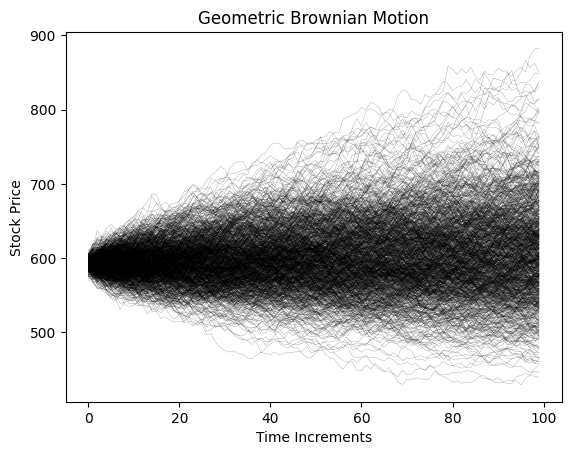

In [67]:
# We will then start by simulating the geometric path of our underlying ETF
import numpy as np
import matplotlib.pyplot as plt


def geo_paths(S, T, r, q, sigma, steps, N):
    """
    Inputs
    #S = Current stock Price
    #K = Strike Price
    #T = Time to maturity 1 year = 1, 1 months = 1/12
    #r = risk free interest rate
    #q = dividend yield
    # sigma = volatility 
    
    Output
    # [steps,N] Matrix of asset paths 
    """
    dt = T/steps
    ST = np.log(S) +  np.cumsum(((r - q - sigma**2/2)*dt +\
                              sigma*np.sqrt(dt) * \
                              np.random.normal(size=(steps,N))),axis=0)
    
    return np.exp(ST)

steps = 100 # time steps
N = 1000 # number of trials
q = 0.00 # annual dividend rate that we assume being 0 on a ETF

paths= geo_paths(S,T,r, q,sigma,steps,N)

plt.plot(paths, 'k', linewidth=0.1)
plt.xlabel("Time Increments")
plt.ylabel("Stock Price")
plt.title("Geometric Brownian Motion")
plt.show()

Let's look at the price distribution.

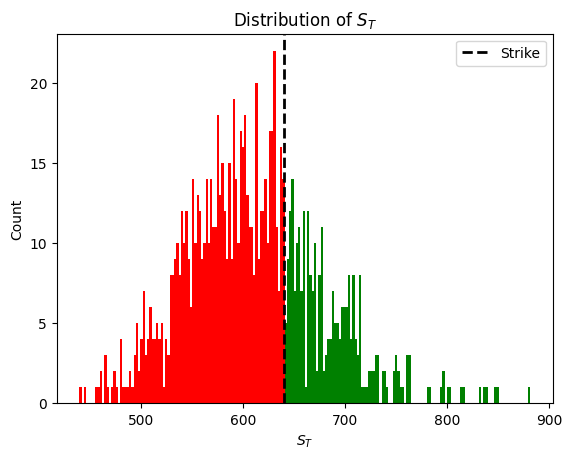

In [68]:
n, bins, patches = plt.hist(paths[-1],bins=200)
for c, p in zip(bins, patches):
    if c > K:
        plt.setp(p, 'facecolor', 'green')
    else:
        plt.setp(p, 'facecolor', 'red')

plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.title("Distribution of $S_{T}$")
plt.xlabel("$S_{T}$")
plt.ylabel('Count')
plt.legend()
plt.show()

In [69]:
# Let's price our option with Monte Carlo simulation
mc_price = MonteCarlo.pricer(S, K, T, r, q, sigma, n_simulations=1000, option_type=option_type)
print(mc_price)

12.933931389431082


As we increase N towards infinity the price approaches the Black-Scholes price, due to  Central Limit Theorem. 

In [70]:
N_simulations = [1000, 100000, 1000000, 10000000, 100000000]
results = []
for N in N_simulations:
    mc_price = MonteCarlo.pricer(
        S, K, T, r, q, sigma, n_simulations=N, option_type=option_type
    )
    results.append((N, mc_price))
mc_prices=[]
for res in results:
    print(f"nb simulation = {res[0]} => option price = {res[1]:.4f}")
    mc_prices.append(res[1])

nb simulation = 1000 => option price = 13.3316
nb simulation = 100000 => option price = 13.8753
nb simulation = 1000000 => option price = 13.7297
nb simulation = 10000000 => option price = 13.7520
nb simulation = 100000000 => option price = 13.7478
